In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from torch import nn
import torch.nn.functional as F
from torch import optim

import torch
import matplotlib.pyplot as plt

import helper

from torchvision import datasets, transforms

In [2]:
#define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5,0.5),
                                                   (0.5, 0.5, 0.5))
                               ])
#download the training set data
trainset = datasets.FashionMNIST('images/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=True)

#download test set data
testset = datasets.FashionMNIST('images/F_MNIST_data/', download=True, train = False, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=True)

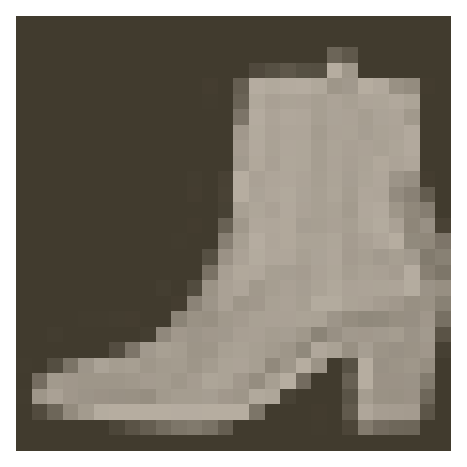

In [3]:
# To see the image
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

**Exercise** 

Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss.

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,10)
        
        #Drop out module with 0.2 drop probability
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        
        #flatten the tensor
        x = x.view(x.shape[0], -1)
        
        #with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        #output, so no dropout
        
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [13]:
#Train the network
epochs = 30
step = 0

train_losses, test_losses = [],[]
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss =0
        accuracy = 0
        
        #turn off gradients, to save memory for validation
        
        with torch.no_grad():
            #Turn off drop out for validation
            model.eval()
            
            for images,labels in testloader:
                output = model(images)
                test_loss += criterion(output,labels)
                
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        #Turn the model back into training
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 0.315..  Test Loss: 0.391..  Test Accuracy: 0.873
Epoch: 2/30..  Training Loss: 0.313..  Test Loss: 0.409..  Test Accuracy: 0.876
Epoch: 3/30..  Training Loss: 0.314..  Test Loss: 0.398..  Test Accuracy: 0.873
Epoch: 4/30..  Training Loss: 0.310..  Test Loss: 0.393..  Test Accuracy: 0.875
Epoch: 5/30..  Training Loss: 0.308..  Test Loss: 0.403..  Test Accuracy: 0.878
Epoch: 6/30..  Training Loss: 0.316..  Test Loss: 0.397..  Test Accuracy: 0.875
Epoch: 7/30..  Training Loss: 0.309..  Test Loss: 0.418..  Test Accuracy: 0.874
Epoch: 8/30..  Training Loss: 0.299..  Test Loss: 0.406..  Test Accuracy: 0.875
Epoch: 9/30..  Training Loss: 0.317..  Test Loss: 0.382..  Test Accuracy: 0.880
Epoch: 10/30..  Training Loss: 0.311..  Test Loss: 0.390..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.307..  Test Loss: 0.408..  Test Accuracy: 0.871
Epoch: 12/30..  Training Loss: 0.297..  Test Loss: 0.419..  Test Accuracy: 0.878
Epoch: 13/30..  Training Loss: 0.305.

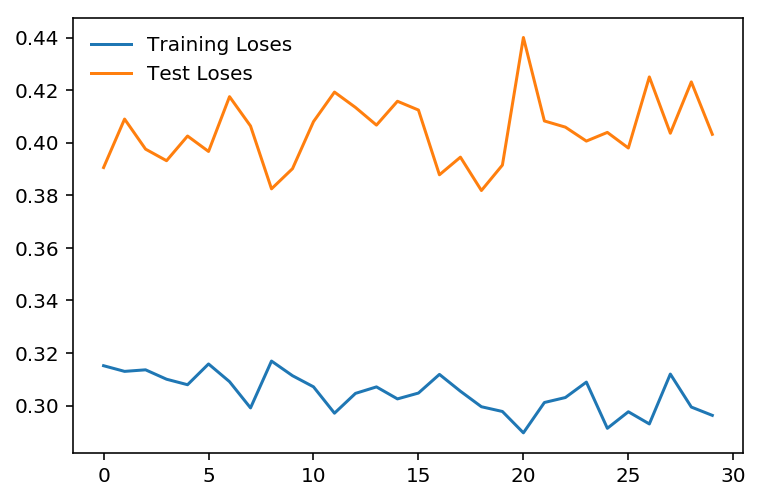

In [14]:
plt.plot(train_losses, label = 'Training Loses')
plt.plot(test_losses, label = 'Test Loses')
plt.legend(frameon=False)


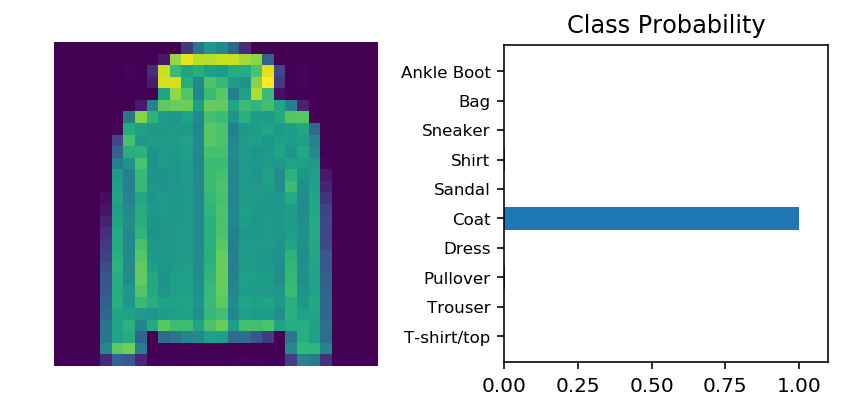

In [20]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')